In [ ]:
#GPU count and name
!nvidia-smi -L

#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

!lscpu |grep 'Model name'

#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

!lscpu | grep "L3 cache"

#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
!lscpu | grep "MHz"

#memory that we can use
!free -h --si | awk  '/Mem:/{print $2}'

#hard disk space that we can use
!df -h / | awk '{print $4}'

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-9d4bdfc5-c1ad-4b95-adcf-433f396ef85b)
Wed Dec  2 22:39:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
           

In [ ]:
PRETRAINED_WEIGHT_NAME=""

In [ ]:
on_colab=True
embedding_dim=300
base_dir="gdrive/MyDrive/News Summary"
glove_dir="glove.6B.{}d.txt".format(embedding_dim)
data_dir=r"Inshorts Cleaned Data.csv"
VERBOSE=1
EPOCH=20
BATCHSIZE=64


In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
import numpy as np
import pandas as pd 
import re
import unicodedata
from bs4 import BeautifulSoup
import io
import json
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import warnings
from matplotlib import pyplot
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
try:
    from google.colab import drive
    drive.mount("/content/gdrive")
except ImportError:
    print("Running on Local")
    on_colab=False
    base_dir=os.getcwd()
    glove_dir=r"C:\Users\fflea\PycharmProjects\CSC790_Deep_Learning\Image-Captioning\glove.6B.{}d.txt".format(embedding_dim)
    data_dir=r"E:\Wikihow\wikihowSep.csv"
    VERBOSE=2


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# if on_colab:    
#     !python -m nltk.downloader stopwords
#     if not os.path.exists(base_dir):
#         os.mkdir(base_dir)

In [ ]:
class AttentionLayer(Layer):
  def init(self, kwargs): super(AttentionLayer, self).init(kwargs)

  def build(self, input_shape):
      assert isinstance(input_shape, list)
      # Create a trainable weight variable for this layer.

      self.W_a = self.add_weight(name='W_a',
                                shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                initializer='uniform',
                                trainable=True)
      self.U_a = self.add_weight(name='U_a',
                                shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                initializer='uniform',
                                trainable=True)
      self.V_a = self.add_weight(name='V_a',
                                shape=tf.TensorShape((input_shape[0][2], 1)),
                                initializer='uniform',
                                trainable=True)

      super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

  def call(self, inputs, verbose=False):
      """
      inputs: [encoder_output_sequence, decoder_output_sequence]
      """
      assert type(inputs) == list
      encoder_out_seq, decoder_out_seq = inputs
      if verbose:
          print('encoder_out_seq>', encoder_out_seq.shape)
          print('decoder_out_seq>', decoder_out_seq.shape)

      def energy_step(inputs, states):
          """ Step function for computing energy for a single decoder state
          inputs: (batchsize * 1 * de_in_dim)
          states: (batchsize * 1 * de_latent_dim)
          """

          assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
          assert isinstance(states, list) or isinstance(states, tuple), assert_msg

          """ Some parameters required for shaping tensors"""
          en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
          de_hidden = inputs.shape[-1]

          """ Computing S.Wa where S=[s0, s1, ..., si]"""
          # <= batch size * en_seq_len * latent_dim
          W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

          """ Computing hj.Ua """
          U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
          if verbose:
              print('Ua.h>', U_a_dot_h.shape)

          """ tanh(S.Wa + hj.Ua) """
          # <= batch_size*en_seq_len, latent_dim
          Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
          if verbose:
              print('Ws+Uh>', Ws_plus_Uh.shape)

          """ softmax(va.tanh(S.Wa + hj.Ua)) """
          # <= batch_size, en_seq_len
          e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
          # <= batch_size, en_seq_len
          e_i = K.softmax(e_i)

          if verbose:
              print('ei>', e_i.shape)

          return e_i, [e_i]

      def context_step(inputs, states):
          """ Step function for computing ci using ei """

          assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
          assert isinstance(states, list) or isinstance(states, tuple), assert_msg

          # <= batch_size, hidden_size
          c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
          if verbose:
              print('ci>', c_i.shape)
          return c_i, [c_i]

      fake_state_c = K.sum(encoder_out_seq, axis=1)
      fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

      """ Computing energy outputs """
      # e_outputs => (batch_size, de_seq_len, en_seq_len)
      last_out, e_outputs, _ = K.rnn(
          energy_step, decoder_out_seq, [fake_state_e],
      )

      """ Computing context vectors """
      last_out, c_outputs, _ = K.rnn(
          context_step, e_outputs, [fake_state_c],
      )

      return c_outputs, e_outputs

  def compute_output_shape(self, input_shape):
      """ Outputs produced by the layer """
      return [
          tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
          tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
      ]



## Reading the data and dropping N/A rows


In [ ]:
nrows=55000
try:
  data=pd.read_csv(os.path.join(base_dir,data_dir),nrows=nrows)
  dataset_name=os.path.splitext(os.path.basename(os.path.join(base_dir,data_dir)))[0]
except FileNotFoundError:
  data=pd.read_csv(data_dir,nrows=nrows)
  dataset_name=os.path.splitext(os.path.basename(data_dir))[0]

In [ ]:
if "Short" in data.columns:
    data.rename(columns = {"Short":"article"}, inplace = True)
    data.rename(columns = {"Headline":"summary"}, inplace = True)
if "headline" in data.columns:
    data.rename(columns = {"text":"article"}, inplace = True)
    data.rename(columns = {"headline":"summary"}, inplace = True)

In [ ]:
print(data.columns)

Index(['summary', 'article', 'Source ', 'Time ', 'Publish Date'], dtype='object')


In [ ]:
print(data.head(5))




                                                        summary  ... Publish Date
0    4 ex-bank officials booked for cheating bank of ₹209 crore  ...   2017-03-26
1                Supreme Court to go paperless in 6 months: CJI  ...   2017-03-25
2  At least 3 killed, 30 injured in blast in Sylhet, Bangladesh  ...   2017-03-25
3         Why has Reliance been barred from trading in futures?  ...   2017-03-25
4   Was stopped from entering my own studio at Times Now: Arnab  ...   2017-03-25

[5 rows x 5 columns]


In [ ]:
data.drop_duplicates(subset=["article"],inplace=True)#dropping duplicates
data = data[pd.notnull(data["article"])]
data = data[pd.notnull(data["summary"])]
#data.dropna(axis=0,inplace=True)#dropping na



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54893 entries, 0 to 54999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   summary       54893 non-null  object
 1   article       54893 non-null  object
 2   Source        54893 non-null  object
 3   Time          54893 non-null  object
 4   Publish Date  54893 non-null  object
dtypes: object(5)
memory usage: 2.5+ MB


## Data Preprocessing

In [ ]:
# replacing many abbreviations and lower casing the words
def clean_words(sentence):
    sentence = str(sentence).lower()
    sentence = unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore') # for converting é to e and other accented chars
    sentence = re.sub(r"http\S+","",sentence)
    sentence = re.sub(r"there's", "there is", sentence)
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    sentence = re.sub(r"'til", "until", sentence)
    sentence = re.sub(r"\"", "", sentence)
    sentence = re.sub(r"\'", "", sentence)
    sentence = re.sub(r' s ', "",sentence)
    sentence = re.sub(r"&39", "", sentence) # the inshorts data has this in it
    sentence = re.sub(r"&34", "", sentence) # the inshorts data has this in it
    sentence = re.sub(r"[\[\]\\0-9()\"$#%/@;:<>{}`+=~|.!?,-]", "", sentence)
    sentence = re.sub(r"&", "", sentence)
    sentence = re.sub(r"\\n", "", sentence)
    sentence = sentence.strip()
    return sentence

In [ ]:
data['cleaned_text'] = data['article'].apply(lambda x: clean_words(x))
data['cleaned_summary'] = data['summary'].apply(lambda x: clean_words(x))



In [ ]:
# Function to calculate maximum text and summary length, upto a certain threshold
def max_length(longs, shorts,  prct):
    # Create a list of all the captions

    length_longs = list(len(d.split()) for d in longs)
    length_shorts = list(len(d.split()) for d in shorts)

    print('percentile {} of length of news: {}'.format(prct,np.percentile(length_longs, prct)))
    print('longest sentence: ', max(length_longs))
    print()
    print('percentile {} of length of summaries: {}'.format(prct,np.percentile(length_shorts, prct)))
    print('longest sentence: ', max(length_shorts))
    print()
    return int(np.percentile(length_longs, prct)),int(np.percentile(length_shorts, prct))

# selecting sentence length based on the percentile of data that fits in the length
max_text_len, max_summary_len= max_length(data['cleaned_text'].to_list(), data['cleaned_summary'].to_list(), 90)


print('max-length text chosen for training: ', max_text_len)
print('max-length summaries chosen for training: ', max_summary_len)




percentile 90 of length of news: 60.0
longest sentence:  66

percentile 90 of length of summaries: 10.0
longest sentence:  14

max-length text chosen for training:  60
max-length summaries chosen for training:  10


In [ ]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({"article":short_text,"summary":short_summary})


In [ ]:
df["summary"] = df["summary"].apply(lambda x : 'sostok '+ x + ' eostok')

We are getting closer to the model building part. Before that, we need to split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df["article"]),np.array(df["summary"]),test_size=0.1,random_state=0,shuffle=False)

## Dataset preparation



In [ ]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))


In [ ]:
thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


% of rare words in vocabulary: 57.91961861881746
Total Coverage of rare words: 2.043872899313112


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  len(x_tokenizer.word_index) + 1

In [ ]:
x_voc


75516

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))


In [ ]:
thresh=5

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)



% of rare words in vocabulary: 70.0120585701981
Total Coverage of rare words: 7.146006986476672


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   len(y_tokenizer.word_index) +1


In [ ]:
y_tokenizer.word_counts['sostok'],len(y_tr)   



(46868, 46868)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Model Building


In [ ]:
latent_dim = 500

In [ ]:
# Preparing GloVe
embeddings_index = {}
try:
  f = open(glove_dir,encoding="utf8")
except FileNotFoundError:
  f = open(os.path.join(base_dir,glove_dir),encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros((x_voc, embedding_dim),dtype='float32')
for word,i in x_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
    # Words not found in glove will be zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras import backend as K 
K.clear_session()


# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,weights=[embedding_matrix],
input_length=max_text_len, trainable=False,  name='embedding_layer')(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 60, 300)      22654800    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 500), (N 1602000     embedding_layer[0][0]            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

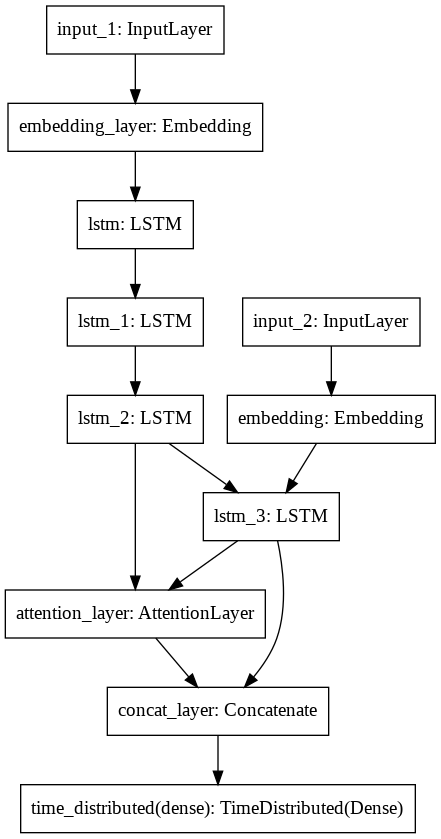

In [ ]:
plot_model(model,os.path.join(base_dir,"plot_model_{}.png".format(embedding_dim)))

In [ ]:
model.compile(optimizer='RMSProp', loss='sparse_categorical_crossentropy')

In [ ]:
# x_tokenizer_json = x_tokenizer.to_json()
# with io.open(os.path.join(base_dir,"x_tokenizer.json"), 'w', encoding='utf-8') as fx:
#     fx.write(json.dumps(x_tokenizer_json, ensure_ascii=False))
#
# y_tokenizer_json = y_tokenizer.to_json()
# with io.open(os.path.join(base_dir,"y_tokenizer.json"), 'w', encoding='utf-8') as fy:
#     fy.write(json.dumps(y_tokenizer_json, ensure_ascii=False))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE,patience=3)

ckp_path=os.path.join(base_dir,"Checkpoints")
if not os.path.exists(ckp_path):
  os.mkdir(ckp_path)
ckp = ModelCheckpoint((os.path.join(ckp_path, "weight.{epoch:02d}-{loss:.3f}-{val_loss:.3f}.h5")))


In [ ]:
if PRETRAINED_WEIGHT_NAME!="" and os.path.exists(os.path.join(base_dir,PRETRAINED_WEIGHT_NAME)):
    model=load_model(os.path.join(base_dir,PRETRAINED_WEIGHT_NAME))
    print("Load pretrained model")

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  verbose=VERBOSE,epochs=EPOCH,
                  callbacks=[es],
                  batch_size=BATCHSIZE,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/20
 90/733 [==>...........................] - ETA: 6:46 - loss: 6.5777

In [ ]:
try:
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.title('Loss')
    pyplot.legend()
    pyplot.savefig(os.path.join(base_dir,"seq_{}_{}_history.png".format(embedding_dim,dataset_name)))
    pyplot.show()
except NameError:
    print("Did not finish training")

In [ ]:
# save_model(model,os.path.join(base_dir,"trained_en_de_{}.h5".format(embedding_dim))) 

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Inference

Set up the inference for the encoder and decoder:

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# save_model(encoder_model,os.path.join(base_dir,"encoder_model_{}.h5".format(embedding_dim))) 
# save_model(decoder_model,os.path.join(base_dir,"decoder_model_{}.h5".format(embedding_dim)))


In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString



In [ ]:
output_str = "original,predicted\n"
for i in range(0,500):
    # print("Review:",seq2text(x_tr[i]))
    # print("Original summary:",seq2summary(y_tr[i]))
    pred=decode_sequence(x_val[i].reshape(1,max_text_len))
    # print("Predicted summary:",pred)
    output_str+="\"{}\",\"{}\"\n".format(seq2summary(y_val[i]),pred)
    # print("\n")  
with open(os.path.join(base_dir,"seq_{}_{}_result.csv".format(embedding_dim,dataset_name)), "w") as writefile:
    writefile.write(output_str)
